<a href="https://colab.research.google.com/github/Geekomaniac1009/MNIST-digit-classification/blob/main/cnn_digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Digit Recognition using CNN (TensorFlow)
Implementation of Convolutional Neural Network using TensorFlow and Keras

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set random seeds for reproducibility
# np.random.seed(42) - Used for consistent random sampling of test images during visualization
# tf.random.set_seed(42) - Used for consistent model initialization and training
np.random.seed(42)
tf.random.set_seed(42)

print(f'TensorFlow version: {tf.__version__}')
# Add these lines
import ipympl
%matplotlib widget
plt.ioff()  # Turn off interactive mode



TensorFlow version: 2.15.0


In [ ]:
# Load and preprocess MNIST dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape for CNN (add channel dimension)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print(f'Training samples: {X_train.shape}')
print(f'Test samples: {X_test.shape}')

Training samples: (60000, 28, 28, 1)
Test samples: (10000, 28, 28, 1)


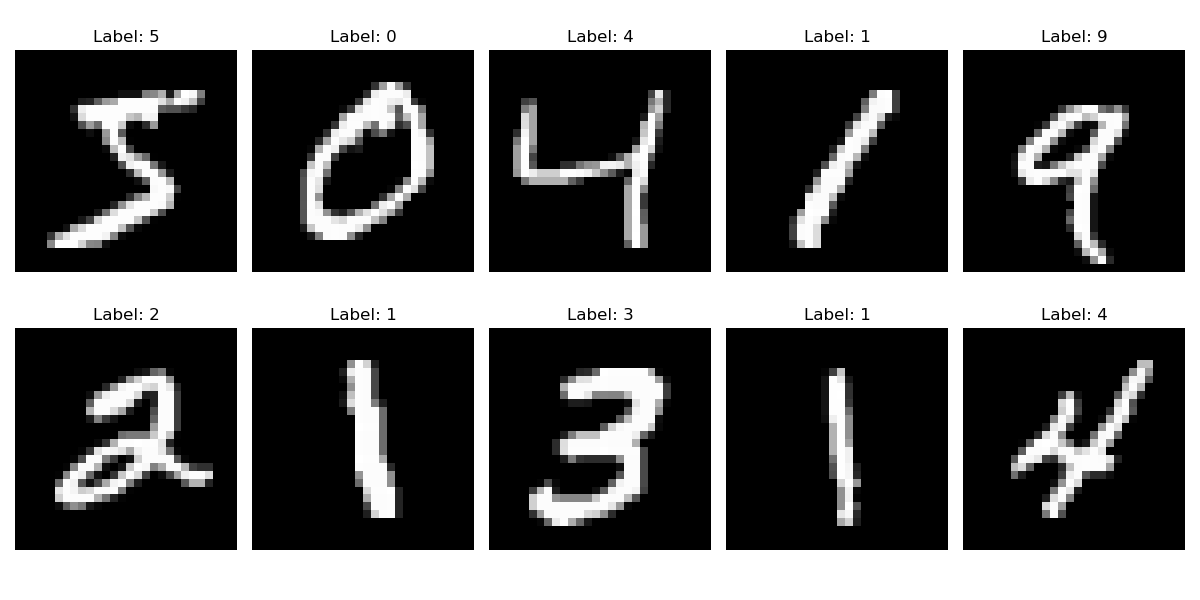

In [ ]:
# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


Original shape: (28, 28, 1)
Augmented shape: (5, 28, 28, 1)


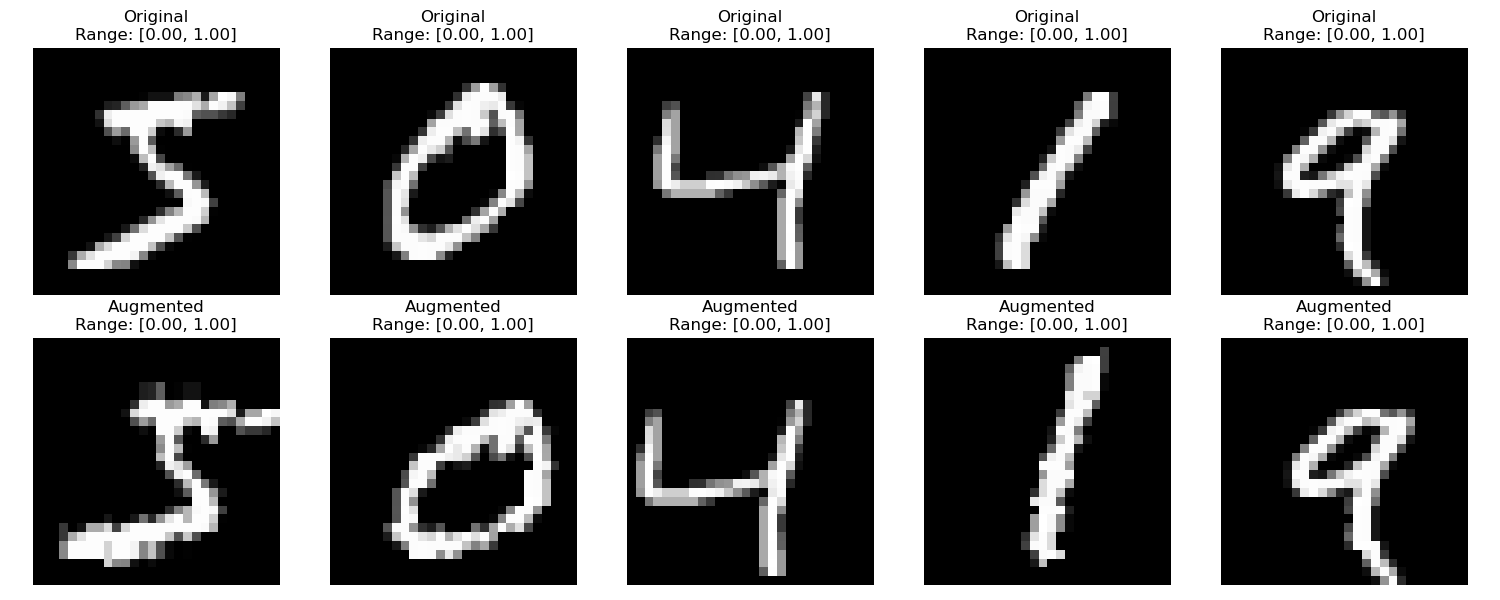

In [ ]:
# Data Augmentation with brightness preservation
# Data Augmentation with strict brightness preservation
data_augmentation = keras.Sequential([
    # Apply augmentations with stricter settings
    keras.layers.experimental.preprocessing.RandomRotation(
        0.1,
        fill_mode='constant',
        interpolation='nearest',
        fill_value=0.0
    ),
    keras.layers.experimental.preprocessing.RandomZoom(
        0.1,
        fill_mode='constant',
        interpolation='nearest',
        fill_value=0.0
    ),
    keras.layers.experimental.preprocessing.RandomTranslation(
        0.1, 0.1,
        fill_mode='constant',
        interpolation='nearest',
        fill_value=0.0
    ),

])
# Display augmentation effects with dimensions
print('Original shape:', X_train[0].shape)  # Should be (28, 28, 1)

# Apply augmentation to some training samples
augmented_samples = data_augmentation(X_train[:5])
print('Augmented shape:', augmented_samples.shape)  # Should be (5, 28, 28, 1)

# Display original vs augmented images with pixel value ranges
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original image
    orig_img = X_train[i].reshape(28, 28)
    axes[0, i].imshow(orig_img, cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'Original\nRange: [{orig_img.min():.2f}, {orig_img.max():.2f}]')
    axes[0, i].axis('off')

    # Augmented image
    aug_img = augmented_samples[i].numpy().reshape(28, 28)
    axes[1, i].imshow(aug_img, cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Augmented\nRange: [{aug_img.min():.2f}, {aug_img.max():.2f}]')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# # Learning Rate Scheduler
# initial_learning_rate = 0.001
# decay_steps = 1000
# decay_rate = 0.9

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps, decay_rate)

# optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
# Create CNN model with data augmentation
model = keras.Sequential([
    # Define input layer explicitly
    keras.layers.Input(shape=(28, 28, 1)),
    # Add augmentation after input layer
    data_augmentation,
    # Rest of the model architecture
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

# Use the scheduled learning rate optimizer
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)       

In [ ]:
# Train the model with callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs')

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=10,
                    validation_split=0.2,
                    callbacks=[early_stopping, tensorboard],
                    verbose=1)

Epoch 1/10


750/750 [==============================] - 23s 27ms/step - loss: 0.7065 - accuracy: 0.7688 - val_loss: 0.0918 - val_accuracy: 0.9715
Epoch 2/10
750/750 [==============================] - 17s 23ms/step - loss: 0.2603 - accuracy: 0.9196 - val_loss: 0.0712 - val_accuracy: 0.9771
Epoch 3/10
750/750 [==============================] - 16s 22ms/step - loss: 0.1974 - accuracy: 0.9407 - val_loss: 0.0535 - val_accuracy: 0.9837
Epoch 4/10
750/750 [==============================] - 18s 24ms/step - loss: 0.1610 - accuracy: 0.9513 - val_loss: 0.0571 - val_accuracy: 0.9830
Epoch 5/10
750/750 [==============================] - 18s 24ms/step - loss: 0.1451 - accuracy: 0.9575 - val_loss: 0.0448 - val_accuracy: 0.9856
Epoch 6/10
750/750 [==============================] - 16s 22ms/step - loss: 0.1336 - accuracy: 0.9604 - val_loss: 0.0460 - val_accuracy: 0.9853
Epoch 7/10
750/750 [==============================] - 18s 25ms/step - loss: 0.1215 - accuracy: 0.9652 - val_loss: 0.0494 - val_accurac

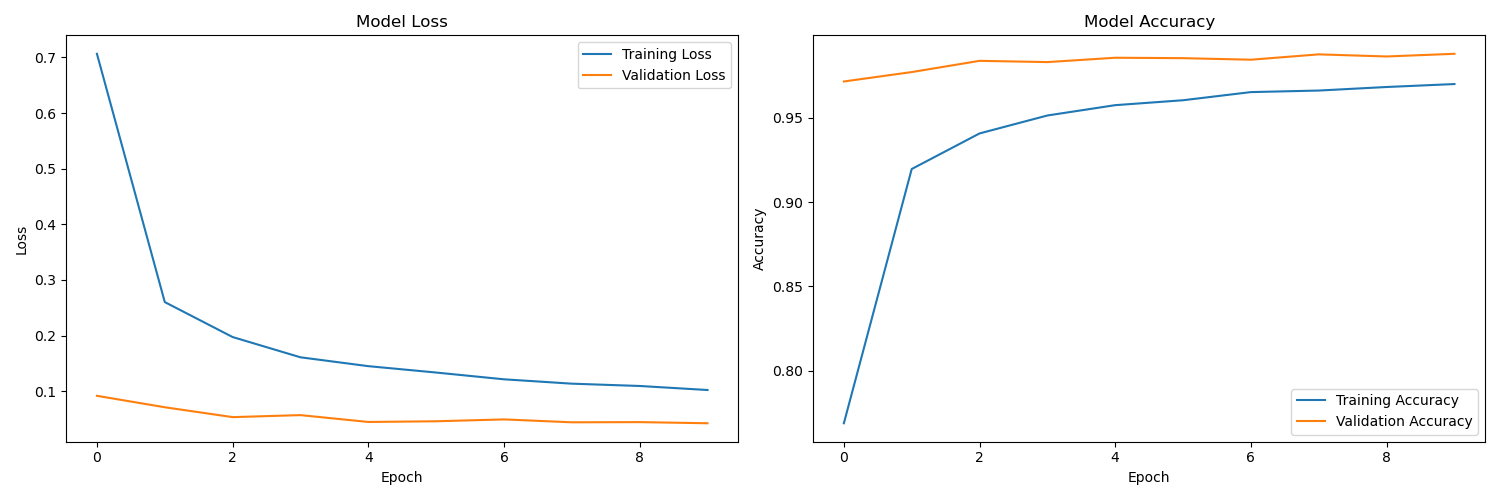

In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

313/313 [==============================] - 2s 5ms/step - loss: 0.0320 - accuracy: 0.9886

Test accuracy: 0.9886
313/313 [==============================] - 2s 5ms/step


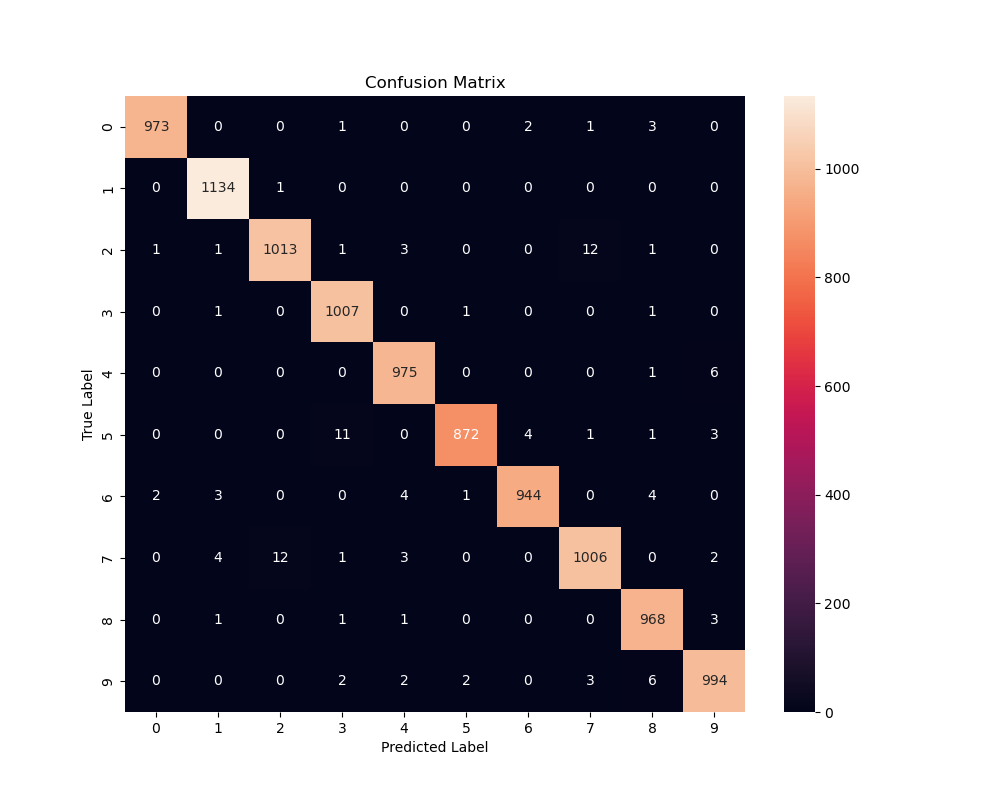

In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'\nTest accuracy: {test_accuracy:.4f}')

# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

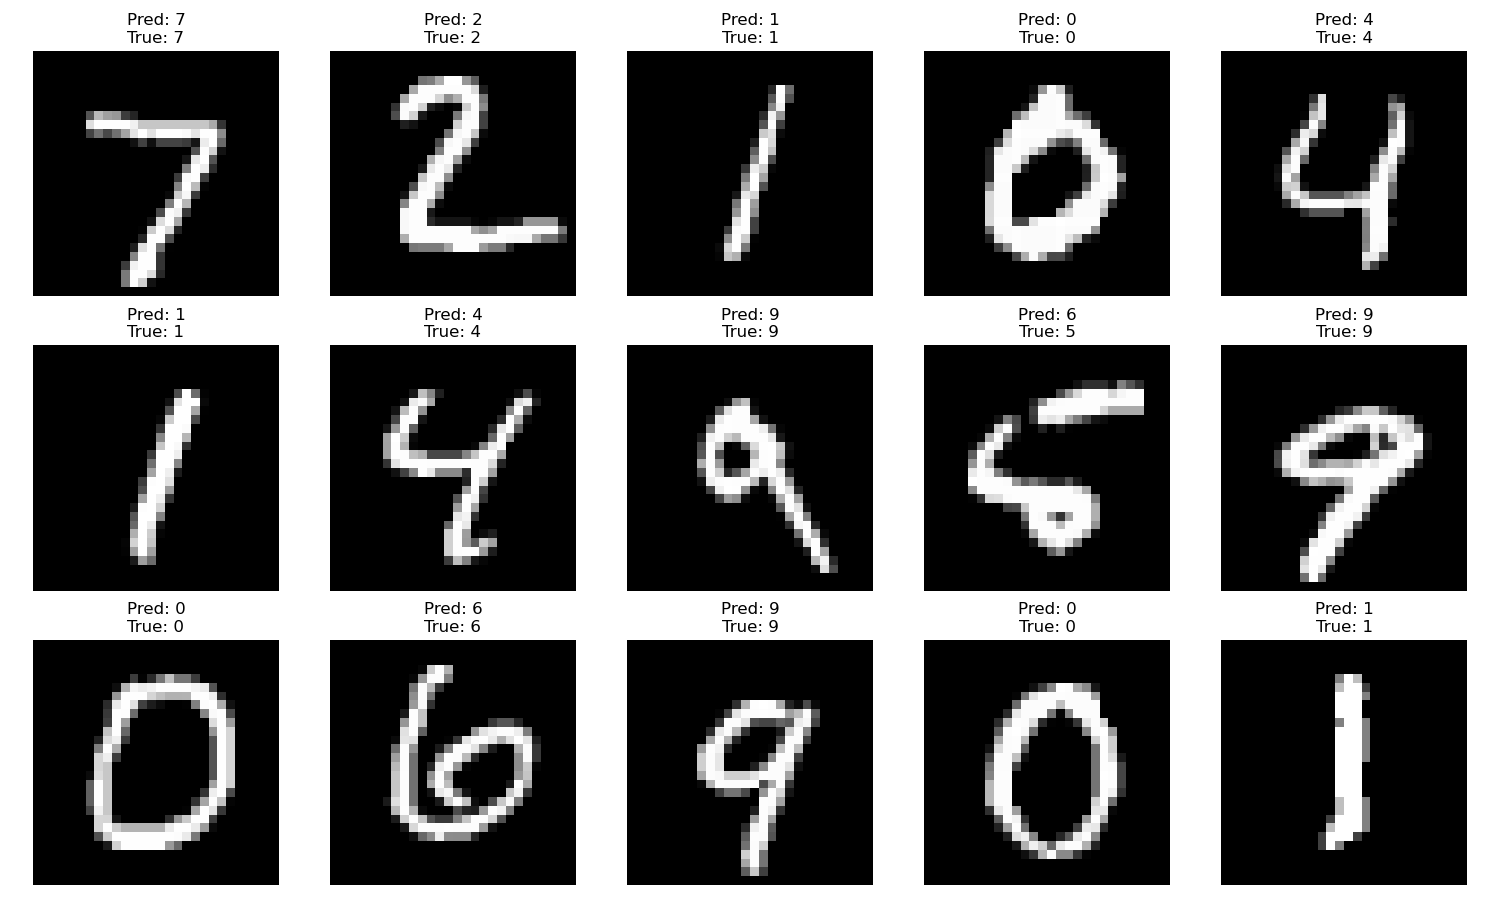

In [ ]:
# Display predictions (with fixed indices for reproducibility)
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
indices = np.arange(15)  # Use first 15 images instead of random selection
for i, ax in enumerate(axes.flat):
    idx = indices[i]
    ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    pred_class = predicted_classes[idx]
    true_class = y_test[idx]
    ax.set_title(f'Pred: {pred_class}\nTrue: {true_class}')
    ax.axis('off')
plt.tight_layout()
plt.show()

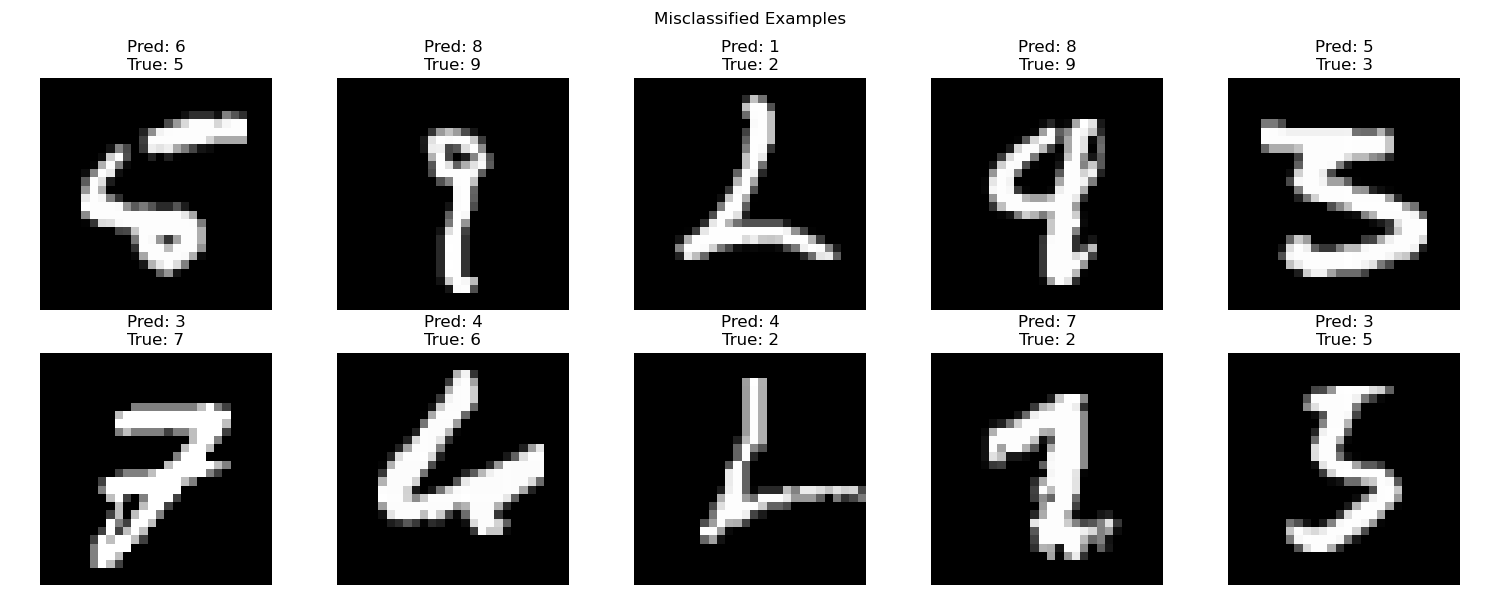

In [ ]:
# Display misclassified examples
misclassified = np.where(predicted_classes != y_test)[0]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < len(misclassified):
        idx = misclassified[i]
        ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        ax.set_title(f'Pred: {predicted_classes[idx]}\nTrue: {y_test[idx]}')
    ax.axis('off')
plt.suptitle('Misclassified Examples')
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.98      0.98      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



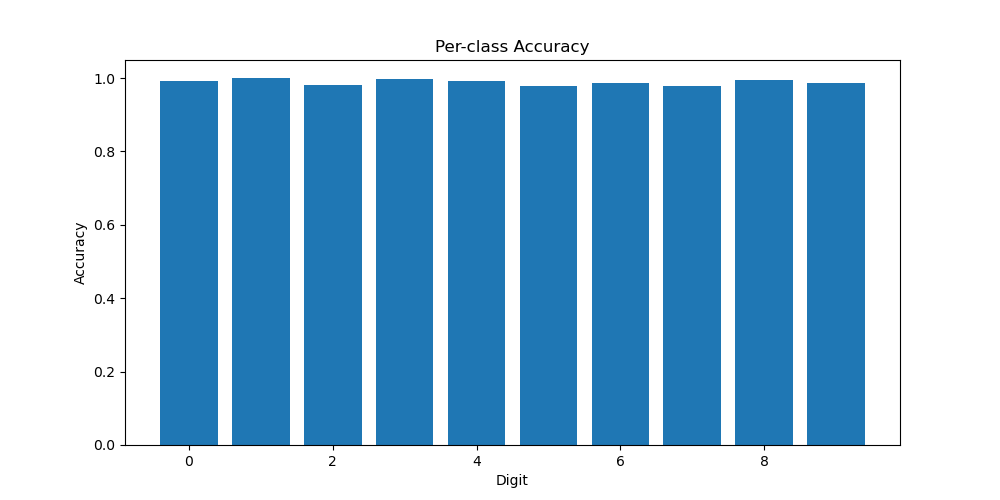

In [ ]:
# Class-wise performance metrics
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, predicted_classes))

# Plot per-class accuracy
class_accuracy = np.zeros(10)
for i in range(10):
    class_mask = y_test == i
    class_accuracy[i] = np.mean(predicted_classes[class_mask] == y_test[class_mask])

plt.figure(figsize=(10, 5))
plt.bar(range(10), class_accuracy)
plt.title('Per-class Accuracy')
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.show()

Visualizing model's attention using Grad-CAM:
Top row: Correctly classified examples
Bottom row: Misclassified examples
Using convolutional layer: conv2d_2


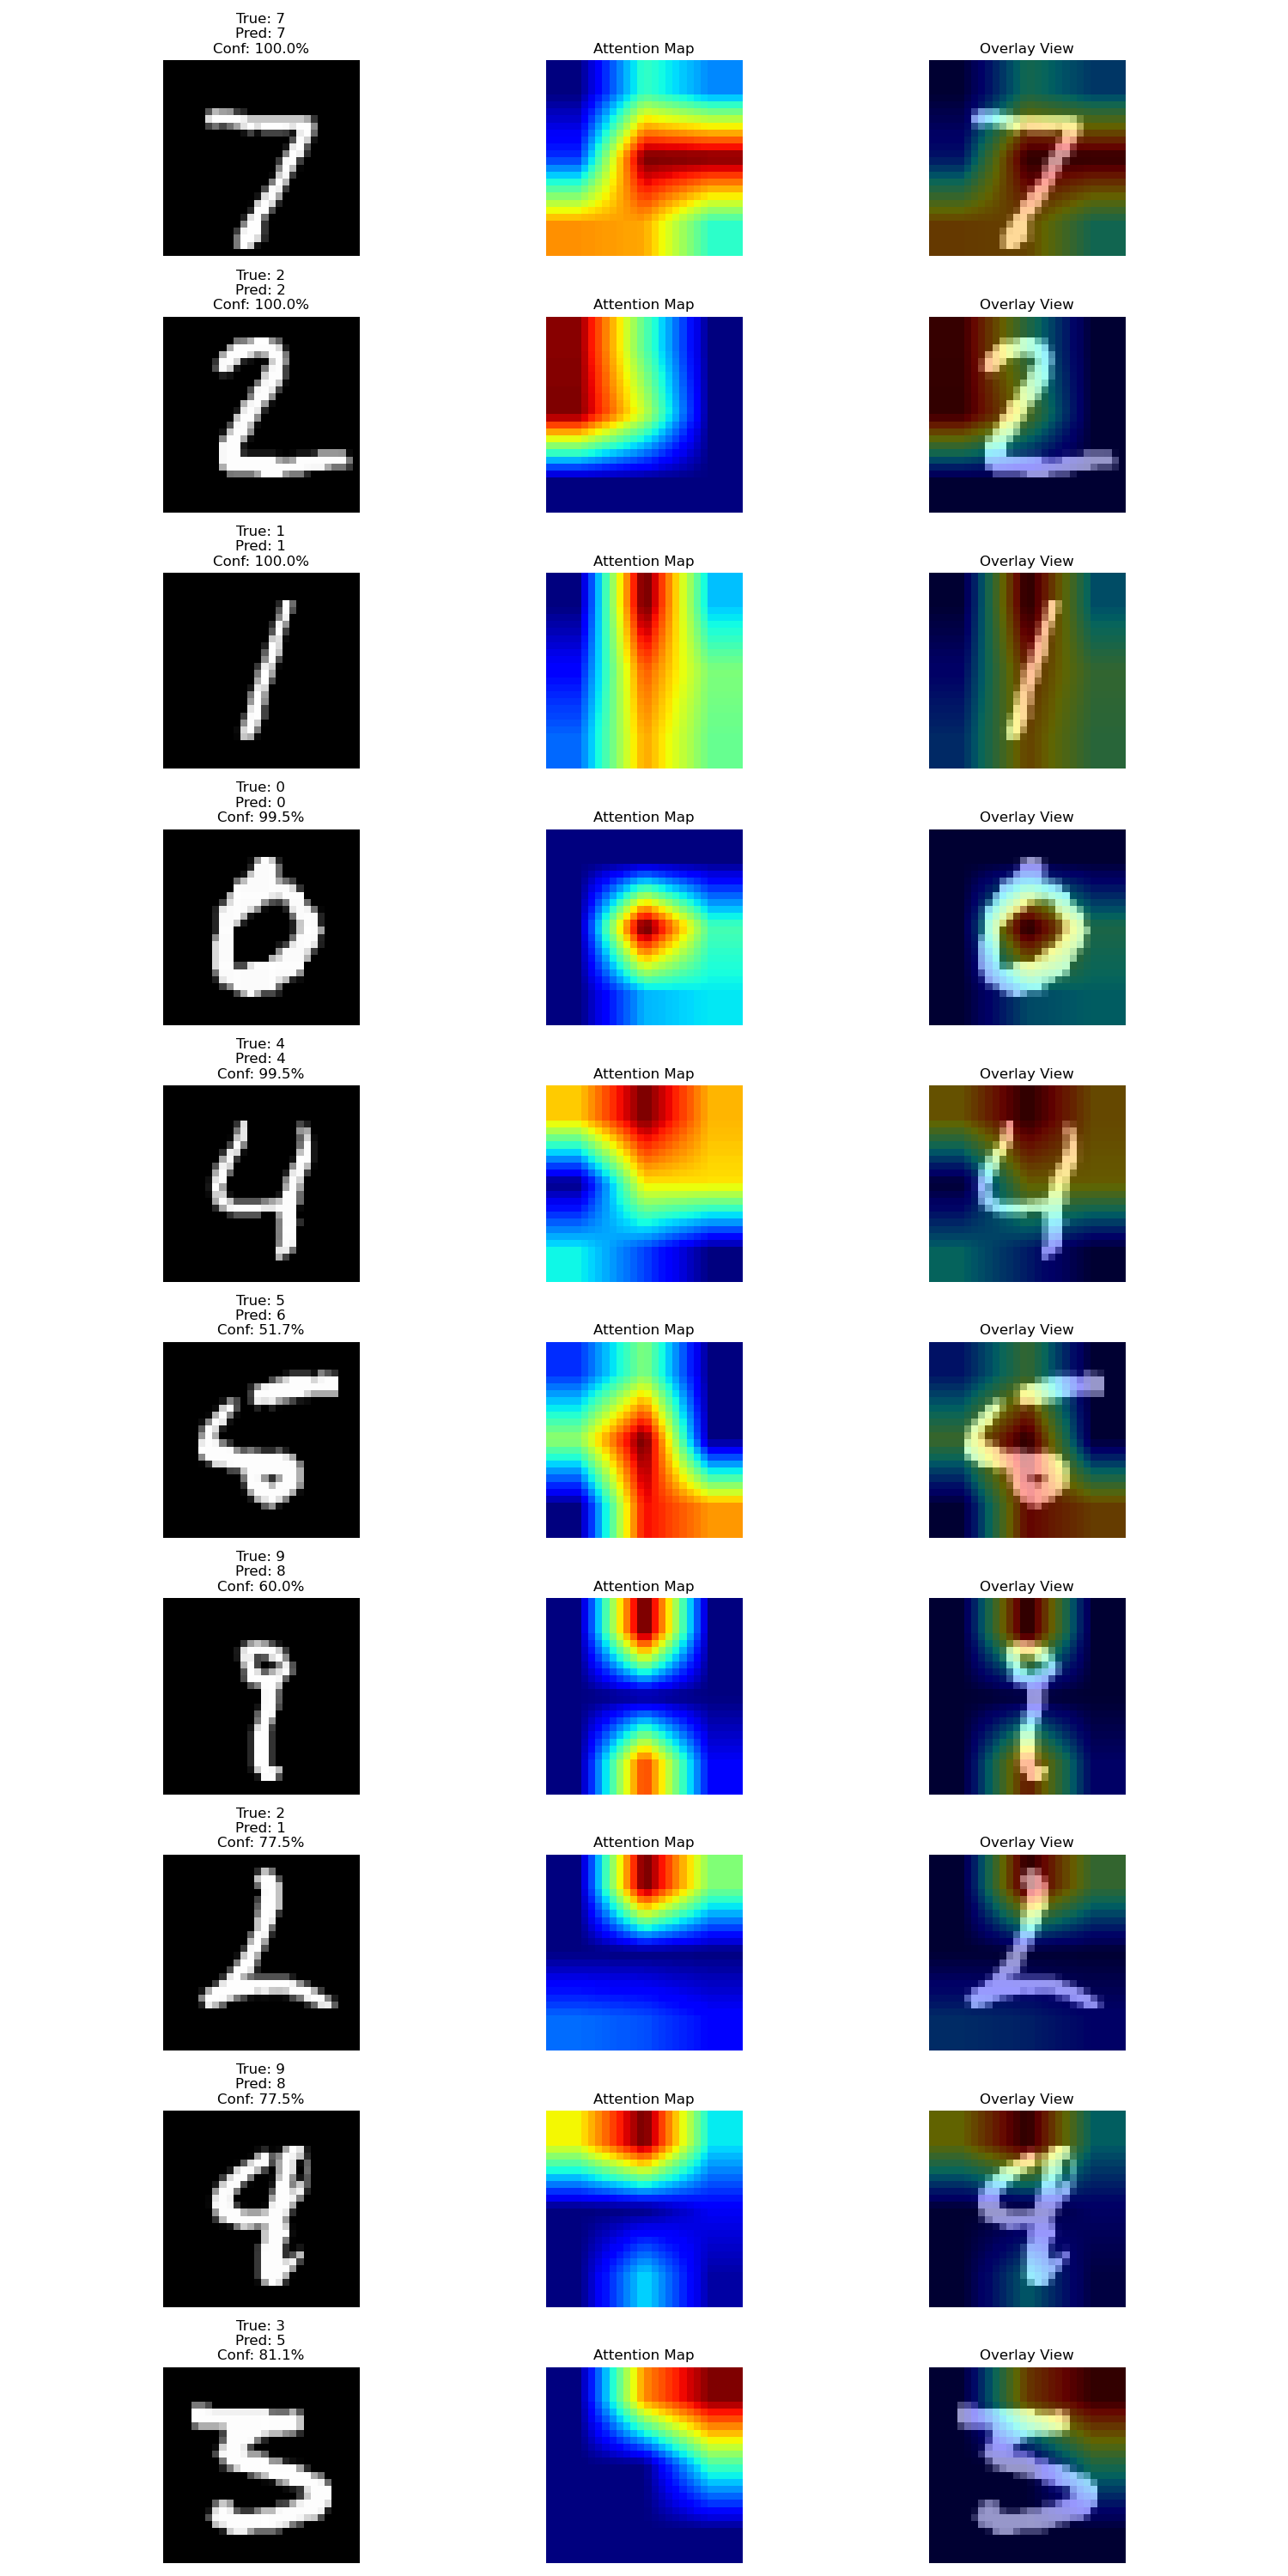

In [ ]:
# Model interpretability using Grad-CAM with improved visualization
from tensorflow.keras.models import Model
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap for model visualization"""

    # Find the last dense layer
    dense_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Dense)]
    last_dense_layer = dense_layers[-1]  # Get the last dense layer

    # Create a model that maps the input image to the last conv layer and predictions
    grad_model = Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            last_dense_layer.output  # Use the last dense layer
        ]
    )

    # Track gradients
    with tf.GradientTape() as tape:
        # Cast image to float32
        img_array = tf.cast(img_array, tf.float32)
        tape.watch(img_array)

        # Get conv output and predictions
        conv_output, predictions = grad_model(img_array, training=False)
        pred_index = tf.argmax(predictions[0]) if pred_index is None else pred_index
        class_channel = predictions[:, pred_index]

    # Get gradients of the target class with respect to the last conv layer
    grads = tape.gradient(class_channel, conv_output)

    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps with gradients
    last_conv_layer_output = conv_output[0]
    heatmap = tf.zeros(last_conv_layer_output.shape[:-1])
    for i in range(pooled_grads.shape[-1]):
        heatmap += last_conv_layer_output[:, :, i] * pooled_grads[i]

    # ReLU and normalize
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())

    # Resize to input size
    heatmap = tf.image.resize(
        tf.expand_dims(heatmap, -1),
        (28, 28),
        method='bilinear'
    )

    return heatmap.numpy()[:,:,0], pred_index.numpy()

def display_gradcam_examples(model, images, labels, num_examples=5):
    """Display Grad-CAM visualizations for multiple examples"""

    # Find last conv layer
    conv_layers = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    last_conv_layer = conv_layers[-1]
    print(f"Using convolutional layer: {last_conv_layer}")

    plt.figure(figsize=(15, 3*num_examples))

    for idx in range(min(len(images), num_examples)):
        img = images[idx:idx+1]
        true_label = labels[idx]

        # Generate heatmap
        heatmap, pred_idx = make_gradcam_heatmap(img, model, last_conv_layer)
        prediction = model.predict(img, verbose=0)
        pred_label = np.argmax(prediction[0])
        confidence = np.max(prediction[0]) * 100

        # Original image
        plt.subplot(num_examples, 3, idx*3 + 1)
        plt.imshow(images[idx].reshape(28, 28), cmap='gray')
        plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%')
        plt.axis('off')

        # Heatmap
        plt.subplot(num_examples, 3, idx*3 + 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title('Attention Map')
        plt.axis('off')

        # Overlay
        plt.subplot(num_examples, 3, idx*3 + 3)
        plt.imshow(images[idx].reshape(28, 28), cmap='gray')
        plt.imshow(heatmap, cmap='jet', alpha=0.4)
        plt.title('Overlay View')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display examples
correct_idx = np.where(predicted_classes == y_test)[0][:5]
incorrect_idx = np.where(predicted_classes != y_test)[0][:5]
sample_idx = np.concatenate([correct_idx, incorrect_idx])

print("Visualizing model's attention using Grad-CAM:")
print("Top row: Correctly classified examples")
print("Bottom row: Misclassified examples")
display_gradcam_examples(
    model=model,
    images=X_test[sample_idx],
    labels=y_test[sample_idx],
    num_examples= sample_idx.shape[0]
)

1/1 [==============================] - 0s 55ms/step


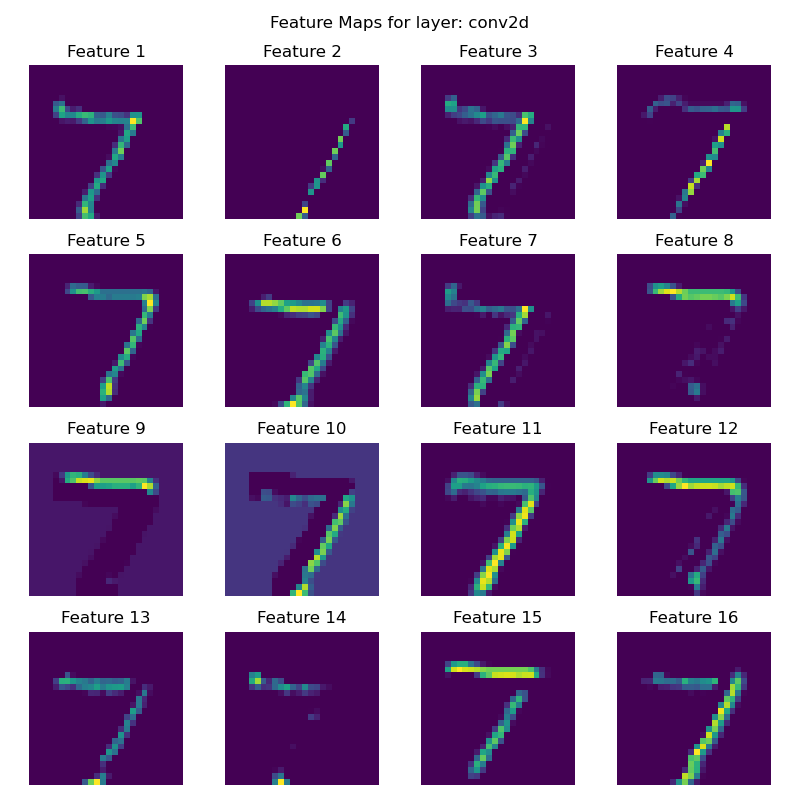

1/1 [==============================] - 0s 161ms/step


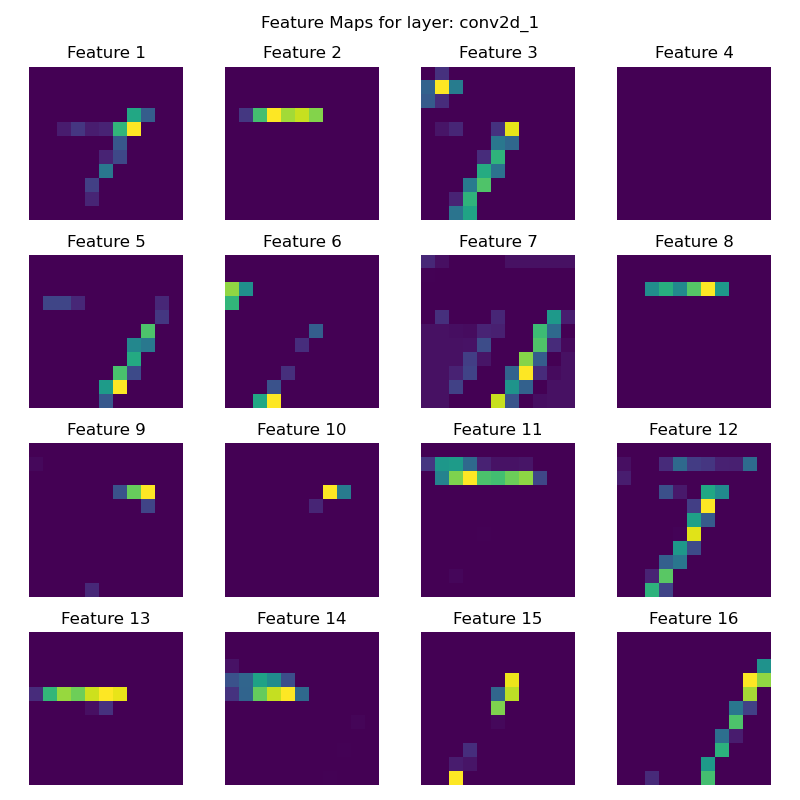

1/1 [==============================] - 0s 95ms/step


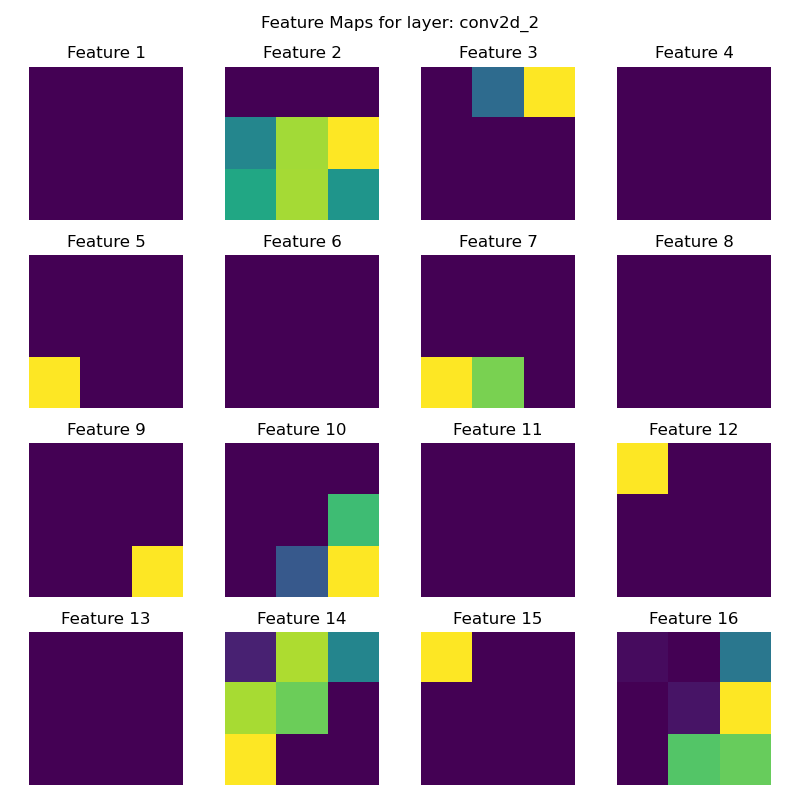

In [ ]:
# Visualize CNN layers
def visualize_layer(layer_name, input_image):
    # Create a model that will output our desired layer's output
    layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Get layer output
    layer_output = layer_model.predict(input_image[np.newaxis, ...])

    # Plot feature maps
    n_features = layer_output.shape[-1]  # number of features in the feature map
    size = layer_output.shape[1]  # feature map shape (1, size, size, n_features)

    # Plot up to 16 features in a 4x4 grid
    n_cols = min(4, n_features)
    n_rows = min(4, (n_features + 3) // 4)

    fig = plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_cols * n_rows):
        if i < n_features:
            ax = fig.add_subplot(n_rows, n_cols, i + 1)
            ax.imshow(layer_output[0, :, :, i])
            ax.set_title(f'Feature {i + 1}')
            ax.axis('off')

    plt.suptitle(f'Feature Maps for layer: {layer_name}')
    plt.tight_layout()
    plt.show()

# Example usage:
sample_image = X_test[0]
# Visualize each convolutional layer
for layer in model.layers:
    if 'conv' in layer.name:
        visualize_layer(layer.name, sample_image)

C:\Users\Sarvesh\AppData\Local\Temp\ipykernel_19292\2568448809.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout


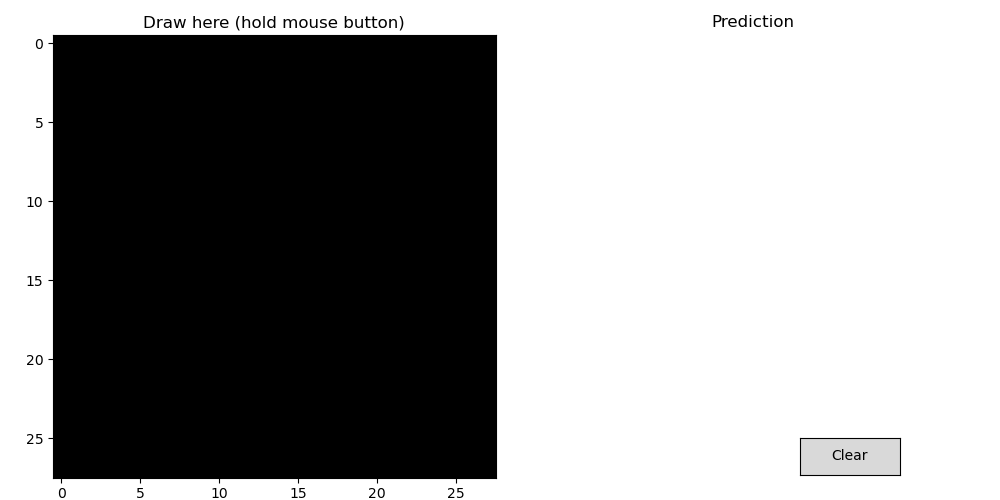

In [ ]:
# Interactive Drawing Interface
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import numpy as np

class DigitDrawer:
    def __init__(self):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(10, 5))
        self.drawing = np.zeros((28, 28))
        self.drawing_active = False

        # Setup the drawing area
        self.ax1.set_title('Draw here (hold mouse button)')
        self.image = self.ax1.imshow(self.drawing, cmap='gray', vmin=0, vmax=1)  # Set value limits
        self.ax1.set_xlim(-0.5, 27.5)  # Adjust plot limits
        self.ax1.set_ylim(27.5, -0.5)  # Invert y-axis for natural drawing

        self.ax2.set_title('Prediction')
        self.prediction_text = self.ax2.text(0.5, 0.5, '', ha='center', va='center', fontsize=20)
        self.ax2.axis('off')

        # Add clear button
        self.clear_button = Button(plt.axes([0.8, 0.05, 0.1, 0.075]), 'Clear')
        self.clear_button.on_clicked(self.clear)

        # Connect events
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_move)

        plt.tight_layout()  # Adjust layout

    def on_press(self, event):
        if event.inaxes == self.ax1:
            self.drawing_active = True
            self.draw_pixel(event)

    def on_release(self, event):
        if self.drawing_active:
            self.drawing_active = False
            self.predict()

    def on_move(self, event):
        if self.drawing_active and event.inaxes == self.ax1:
            self.draw_pixel(event)

    def draw_pixel(self, event):
        x, y = int(event.xdata), int(event.ydata)
        if 0 <= x < 28 and 0 <= y < 28:
            # Draw with a thicker brush (3x3)
            for dx in [ 0, 1]:
                for dy in [ 0, 1]:
                    if 0 <= x+dx < 28 and 0 <= y+dy < 28:
                        self.drawing[y+dy, x+dx] = 1
            self.image.set_data(self.drawing)
            self.fig.canvas.draw_idle()

    def clear(self, event):
        self.drawing.fill(0)
        self.image.set_data(self.drawing)
        self.prediction_text.set_text('')
        self.fig.canvas.draw_idle()

    def predict(self):
        # Prepare image for prediction
        img = self.drawing.reshape(1, 28, 28, 1)
        prediction = model.predict(img, verbose=0)  # Add verbose=0 to reduce output
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction) * 100

        # Update prediction display
        self.prediction_text.set_text(f'Predicted: {predicted_class}\nConfidence: {confidence:.1f}%')
        self.fig.canvas.draw_idle()

# Create and show the drawing interface
drawer = DigitDrawer()
plt.show()